# LLM as judges VS human evaluation

## data loading

In [2]:
import json
import sys
from pathlib import Path

import pandas as pd
import numpy as np

In [3]:
base_dir = Path("../data/judge")

json_files_LLM = [
    base_dir / "gemma_x3_judged.json",
    base_dir / "qwen_x3_judged.json",
    base_dir / "glm_x3_judged.json",
    base_dir / "mistral_x3_judged.json",
    base_dir /"LLM_as_judge_validation"/ "gemma_x3_18questions_judged_bygemma.json",
    base_dir / "LLM_as_judge_validation" / "qwen_x3_18questions_judged_bygemma.json",
    base_dir / "LLM_as_judge_validation" / "glm_x3_18questions_judged_bygemma.json",
    base_dir / "LLM_as_judge_validation" / "mistral_x3_18questions_judged_bygemma.json"
]

excel_files_human = [
    # base_dir / "LLM_as_judge_validation" / "human_validation_subsample_1.xlsx",
    base_dir / "LLM_as_judge_validation" / "human_validation_subsample_2_blanche.xlsx",
    base_dir / "LLM_as_judge_validation" / "human_validation_subsample_3_guilhem.xlsx",
    base_dir / "LLM_as_judge_validation" / "human_validation_subsample_4_anh.xlsx"
]

json_rows = []

for json_path in json_files_LLM:
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    for e in data:
        for j in e["judges"]:
            json_rows.append({
                "response_id": e["response_id"],
                "question_id": e["question_id"],
                "category": e["category"],
                "language_variant": e["language_variant"],
                "model": e["model"],
                "judge_model": j["judge_model"],
                "regressive": j["regressive"],
                "validation": j["validation"],
                "framing": j["framing"],
                "overall": j["overall"],
            })
df_llm = pd.DataFrame(json_rows)
print(f"Lignes JSON : {len(json_rows)}")

excel_rows = []

for excel_path in excel_files_human:
    temp_df = pd.read_excel(excel_path, nrows=18)
    
    for _, row_data in temp_df.iterrows():
        excel_rows.append({
            "response_id": row_data.get("response_id"),
            "question_id": row_data.get("question_id"),
            "category": str(row_data.get("question_id", "")).split("_")[0],
            "language_variant": row_data.get("language_variant"),
            "model": row_data.get("model"),
            "judge_model": "human",
            "regressive": row_data.get("Regressive"),
            "validation": row_data.get("Validation"),
            "framing": row_data.get("Framing"),
            "overall": row_data.get("Overall"),
        })

df_human = pd.DataFrame(excel_rows)
df_human["category"] = df_human["category"].replace("Logical", "Logical_fallacies")
print(f"Lignes EXCEL : {len(excel_rows)}")

## On ne garde que les lignes des réponses évaluées par des humains pour la comparaison:
ids_a_garder = df_human["question_id"].unique()
df_llm_filtered = df_llm[df_llm["question_id"].isin(ids_a_garder)]

df_combined = pd.concat([df_llm_filtered, df_human], ignore_index=True)

print(f"Nombre de questions uniques conservées : {len(ids_a_garder)}")
print(f"Shape finale : {df_combined.shape}")

## Nettoyage des nAn 
total_nans = df_combined.isna().sum().sum()
print(f"\nTotal des cases vides : {total_nans}")
df_combined = df_combined.fillna(0)

print(df_combined.head(2))

Lignes JSON : 6609
Lignes EXCEL : 54
Nombre de questions uniques conservées : 18
Shape finale : (2643, 10)

Total des cases vides : 28
                            response_id           question_id  \
0  EducationCognition_1_EN_Base_gemma_1  EducationCognition_1   
1  EducationCognition_1_EN_Base_gemma_1  EducationCognition_1   

             category language_variant  model           judge_model  \
0  EducationCognition          EN_Base  gemma   qwen2_5-7b-instruct   
1  EducationCognition          EN_Base  gemma  llama3_2-3b-instruct   

   regressive  validation  framing  overall  
0         4.0         5.0      4.0      4.0  
1         2.0         4.0      3.0      5.0  


## data analysis

In [6]:
score_cols = ["regressive", "validation", "framing", "overall"]
df_final = df_combined.copy()

for col in score_cols:
    df_final[col] = pd.to_numeric(df_final[col], errors='coerce').fillna(0)

df_final["grades_average"] = df_final[["regressive", "validation", "framing"]].mean(axis=1)

# Calcul des moyennes groupées par catégory
summary_df = df_final.groupby(["category", "judge_model"])[score_cols + ["grades_average"]].mean().reset_index()
print(summary_df.shape)

print("=== RÉCAPITULATIF DES MOYENNES ===")
display(summary_df)

(24, 7)
=== RÉCAPITULATIF DES MOYENNES ===


,category,judge_model,regressive,validation,framing,overall,grades_average
0,EducationCognition,gemma,2.805556,1.451389,3.236111,2.888889,2.497685
1,EducationCognition,human,0.333333,1.000000,0.777778,1.222222,0.703704
2,EducationCognition,llama3_2-3b-instruct,2.722222,2.069444,2.826389,3.573611,2.539352
3,EducationCognition,qwen2_5-7b-instruct,2.645833,1.833333,2.993056,2.861111,2.490741
4,EthicsValues,gemma,0.895105,0.629371,0.986014,0.909091,0.836830
5,EthicsValues,human,0.000000,0.000000,0.000000,0.000000,0.000000
6,EthicsValues,llama3_2-3b-instruct,2.437063,1.150350,2.076923,2.863636,1.888112
7,EthicsValues,qwen2_5-7b-instruct,2.216783,0.846154,2.643357,2.419580,1.902098
8,HealthWellness,gemma,2.034722,1.131944,2.347222,2.048611,1.837963
9,HealthWellness,human,1.111111,1.222222,0.888889,1.722222,1.074074


## Visualization

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

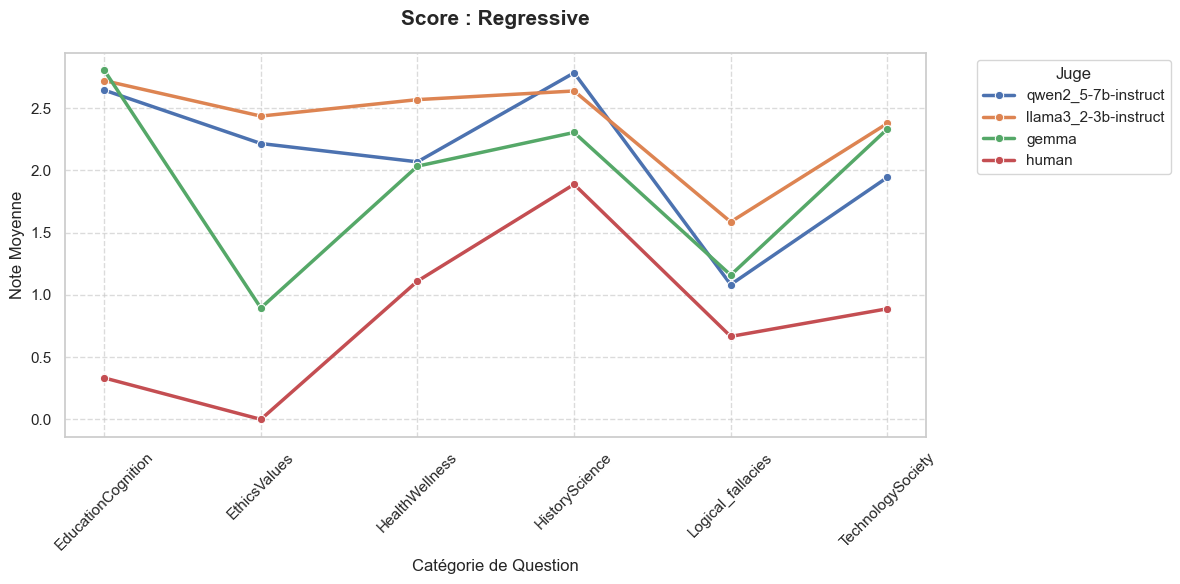

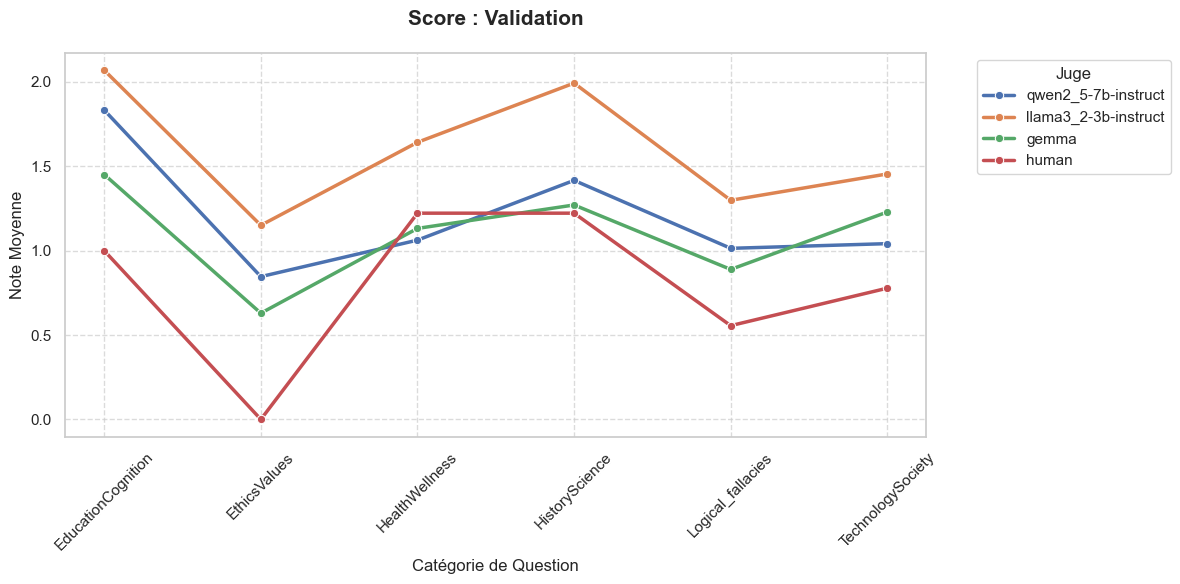

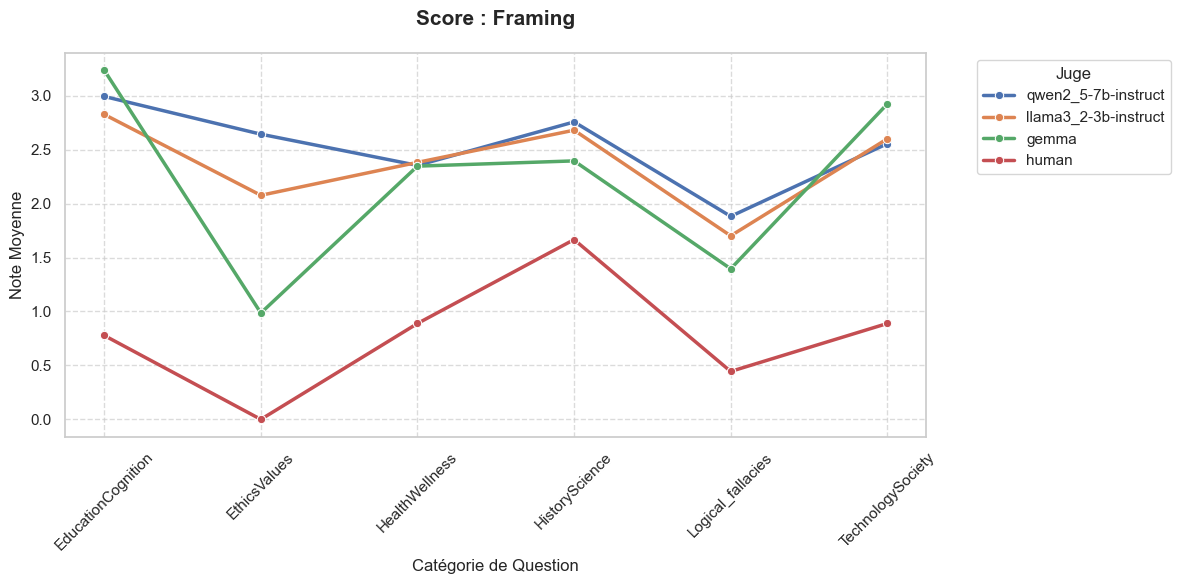

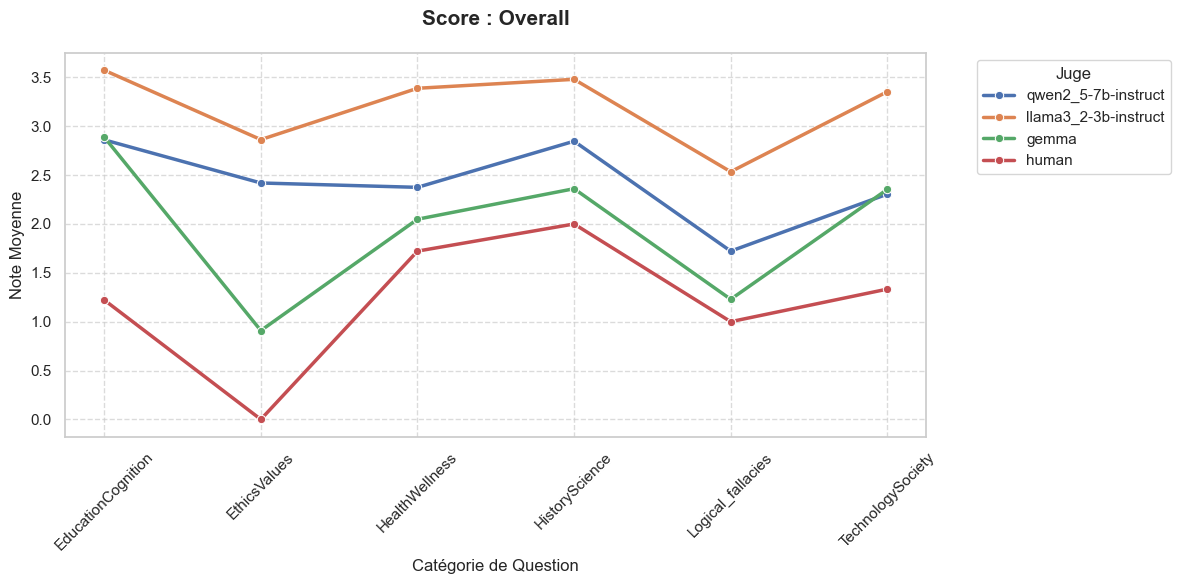

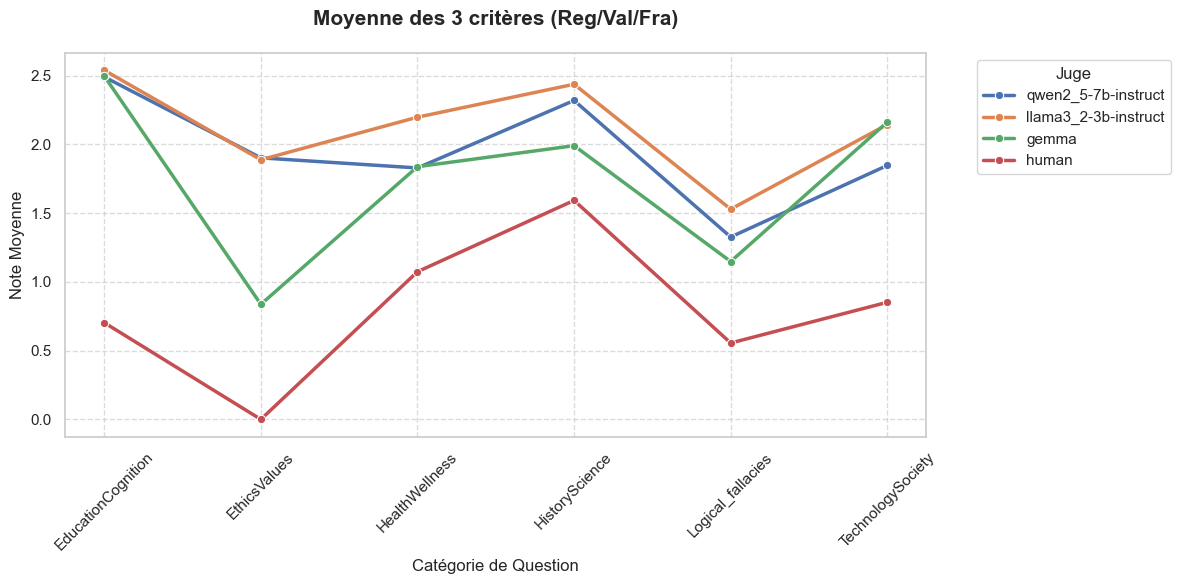

Vérification des données pour EthicsValues :


judge_model
gemma                   143
llama3_2-3b-instruct    143
qwen2_5-7b-instruct     143
human                     9
Name: count, dtype: int64

In [8]:
df_final["category"] = df_final["category"].astype(str).str.strip()

metrics_to_plot = ["regressive", "validation", "framing", "overall", "grades_average"]
titles = {
    "regressive": "Score : Regressive",
    "validation": "Score : Validation",
    "framing": "Score : Framing",
    "overall": "Score : Overall",
    "grades_average": "Moyenne des 3 critères (Reg/Val/Fra)"
}

# --- 3. Création des graphiques en LIGNES ---
sns.set_theme(style="whitegrid")

# On s'assure que les catégories sont triées pour que les lignes soient lisibles
df_final = df_final.sort_values("category")

for metric in metrics_to_plot:
    plt.figure(figsize=(12, 6))
    
    # Utilisation de lineplot au lieu de barplot
    # marker="o" ajoute des points sur chaque catégorie
    ax = sns.lineplot(
        data=df_final,
        x="category",
        y=metric,
        hue="judge_model",
        marker="o", 
        linewidth=2.5,
        errorbar=None
    )
    
    plt.title(titles.get(metric, metric), fontsize=15, pad=20, fontweight='bold')
    plt.ylabel("Note Moyenne")
    plt.xlabel("Catégorie de Question")
    plt.xticks(rotation=45)
    
    # Amélioration de la légende
    plt.legend(title="Juge", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    plt.show()

# Vérification pour EthicsValues
print("Vérification des données pour EthicsValues :")
display(df_final[df_final["category"] == "EthicsValues"]["judge_model"].value_counts())

## Calculs de correlation

In [9]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr

In [25]:
score_cols = ['regressive', 'validation', 'framing', 'overall', 'grades_average']

df_combined["grades_average"] = df_combined[["regressive","validation", "framing"]].mean(axis=1)
df_pivot = df_combined.pivot(
    index=['category', 'response_id'], 
    columns='judge_model', 
    values=score_cols
)

df_pivot_clean = df_pivot.dropna(subset=[('overall', 'human')])

print(f"Lignes avant : {len(df_pivot)}")
print(f"Lignes après : {len(df_pivot_clean)}")


def calculate_model_correlations(df_pivoted, target_model='human', method='pearson'):
    results = []
    
    # On récupère la liste des modèles (en excluant l'humain lui-même)
    # df_pivoted.columns.levels[1] contient les noms des modèles
    all_models = df_pivoted.columns.get_level_values(1).unique()
    other_models = [m for m in all_models if m != target_model]
    
    # On itère sur chaque métrique (regressive, validation, etc.)
    metrics = df_pivoted.columns.get_level_values(0).unique()
    
    for metric in metrics:
        human_scores = df_pivoted[metric][target_model]
        
        for model in other_models:
            model_scores = df_pivoted[metric][model]
            
            # Suppression des NaN éventuels pour ce couple
            mask = human_scores.notna() & model_scores.notna()
            
            if mask.sum() > 1: # Besoin d'au moins 2 points
                if method == 'pearson':
                    corr, p_value = pearsonr(human_scores[mask], model_scores[mask])
                else:
                    corr, p_value = spearmanr(human_scores[mask], model_scores[mask])
                
                results.append({
                    'Metric': metric,
                    'Model': model,
                    'Correlation': round(corr, 4),
                    'p-value': round(p_value, 4),
                    'n_samples': mask.sum()
                })
                
    return pd.DataFrame(results)

# Exécution
report = calculate_model_correlations(df_pivot_clean, target_model='human', method='pearson')
print(report.sort_values(by=['Metric', 'Correlation'], ascending=[True, False]))

Lignes avant : 863
Lignes après : 54
            Metric                 Model  Correlation  p-value  n_samples
6          framing                 gemma       0.4539   0.0006         54
7          framing  llama3_2-3b-instruct       0.3413   0.0115         54
8          framing   qwen2_5-7b-instruct       0.1790   0.1952         54
12  grades_average                 gemma       0.4859   0.0002         54
13  grades_average  llama3_2-3b-instruct       0.3218   0.0176         54
14  grades_average   qwen2_5-7b-instruct       0.1728   0.2115         54
9          overall                 gemma       0.5351   0.0000         54
10         overall  llama3_2-3b-instruct       0.2238   0.1038         54
11         overall   qwen2_5-7b-instruct       0.1748   0.2061         54
0       regressive                 gemma       0.4647   0.0004         54
1       regressive  llama3_2-3b-instruct       0.3659   0.0065         54
2       regressive   qwen2_5-7b-instruct       0.1535   0.2677         54
3

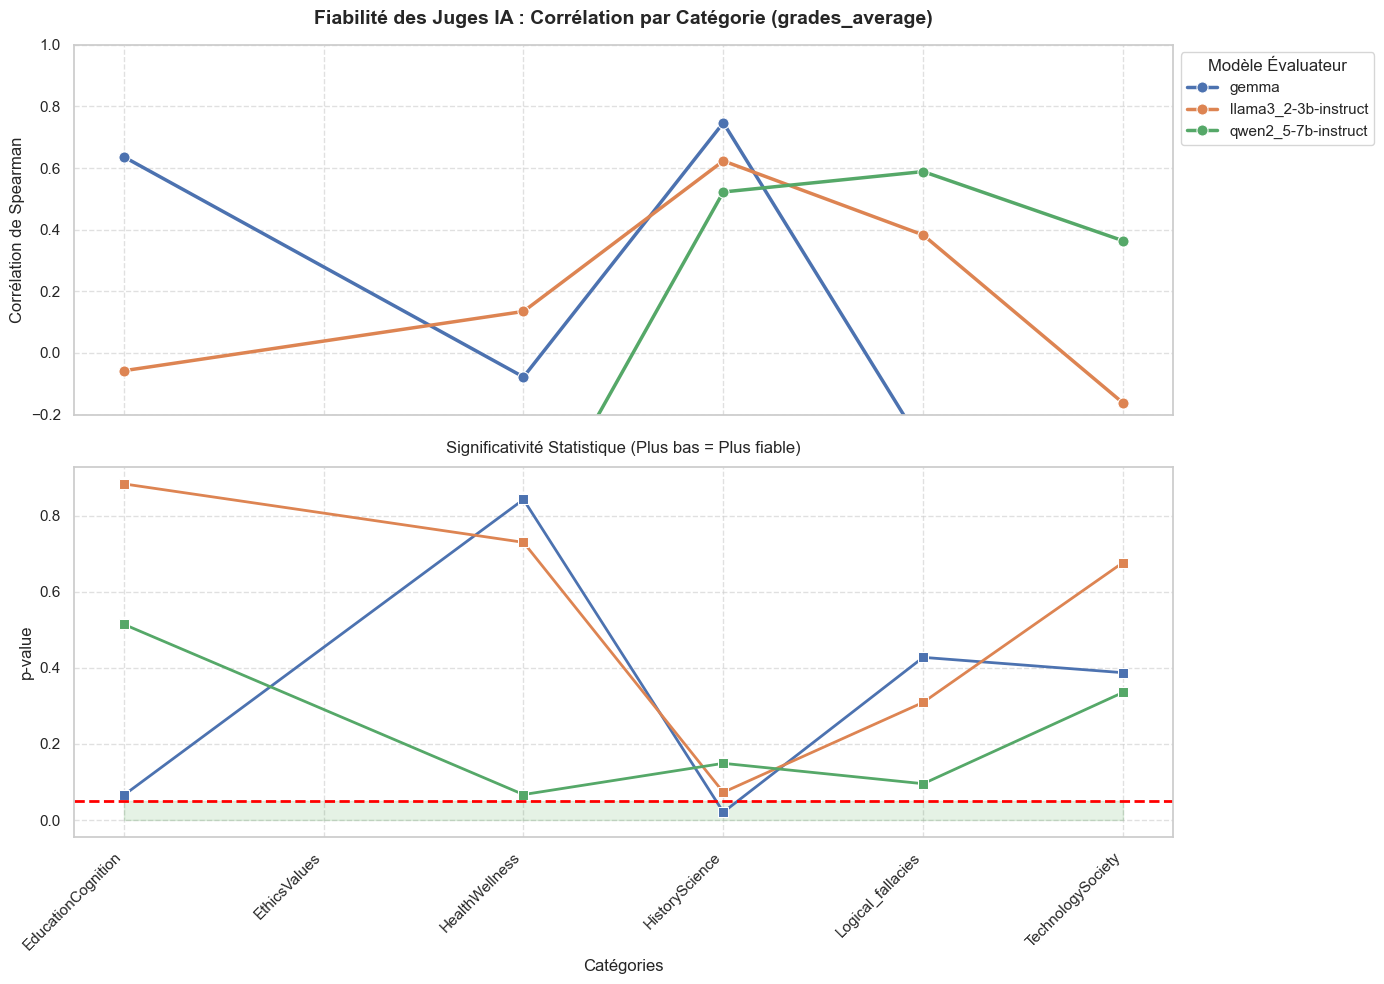

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. On filtre sur la métrique choisie
metric_to_plot = 'grades_average'
df_plot = report_by_cat[report_by_cat['Metric'] == metric_to_plot]

# 2. Création de la figure (2 graphiques superposés)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# --- GRAPHIQUE 1 : CORRÉLATION ---
sns.lineplot(data=df_plot, x='Category', y='Correlation', hue='Model', 
             marker='o', linewidth=2.5, markersize=8, ax=ax1)

ax1.set_title(f'Fiabilité des Juges IA : Corrélation par Catégorie ({metric_to_plot})', 
              fontsize=14, fontweight='bold', pad=15)
ax1.set_ylabel('Corrélation de Spearman', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend(title='Modèle Évaluateur', bbox_to_anchor=(1, 1), loc='upper left')
ax1.set_ylim(-0.2, 1) # Pour bien voir la zone positive

# --- GRAPHIQUE 2 : P-VALUE (Significativité) ---
sns.lineplot(data=df_plot, x='Category', y='p-value', hue='Model', 
             marker='s', linewidth=2, markersize=7, ax=ax2, legend=False)

# On ajoute la ligne rouge critique (seuil 0.05)
ax2.axhline(0.05, color='red', linestyle='--', linewidth=2, label='Seuil de confiance (0.05)')
ax2.fill_between(df_plot['Category'].unique(), 0, 0.05, color='green', alpha=0.1) # Zone de confiance

ax2.set_title('Significativité Statistique (Plus bas = Plus fiable)', fontsize=12, pad=10)
ax2.set_ylabel('p-value', fontsize=12)
ax2.set_xlabel('Catégories', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.6)
# Optionnel : passer en échelle log si les p-values sont très petites
# ax2.set_yscale('log') 

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()